# Setup

In [1]:
!pip install -q modelscan
!modelscan -v

modelscan, version 0.5.0


In [2]:
!pip install -q tensorflow==2.13.0
!pip install -q transformers==4.31.0
!pip install -q matplotlib==3.7.2

In [3]:
import tensorflow as tf
import os

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from utils.tensorflow_fashion_mnist_model import train_model, get_predictions
from utils.tensorflow_codeinjection import MaliciousModule

# Saving Model

The Tensorflow model used in the notebook is for classification of fashion/clothing items and trained on fashion mnist dataset. [Reference to Tensorflow tutorial for classification of fashion mnist dataset](https://www.tensorflow.org/tutorials/keras/classification). The safe model is saved at `TensorFlowModels/safe_model`. 

In [4]:
model_directory = "TensorFlowModels"
if not os.path.isdir(model_directory):
    os.mkdir(model_directory)


safe_model_path = os.path.join(model_directory, "safe_model")
model = train_model()
model.save(safe_model_path)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4993 - accuracy: 0.8256
Epoch 2/10
1875/1875 [==============================] - 2s 915us/step - loss: 0.3759 - accuracy: 0.8643
Epoch 3/10
1875/1875 [==============================] - 2s 925us/step - loss: 0.3380 - accuracy: 0.8761
Epoch 4/10
1875/1875 [==============================] - 2s 919us/step - loss: 0.3125 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 2s 947us/step - loss: 0.2955 - accuracy: 0.8910
Epoch 6/10
1875/1875 [==============================] - 2s 839us/step - loss: 0.2819 - accuracy: 0.8951
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2708 - accuracy: 0.9000
Epoch 8/10
1875/1875 [==============================] - 2s 983us/step - loss: 0.2577 - accuracy: 0.9047
Epoch 9/10
1875/1875 [==============================] - 2s 983us/step - loss: 0.2496 - accuracy: 0.9065
Epoch 10/10
313/313 [==============================] - 0s 564us/step

# Safe Model Prediction 

1/1 [==============================] - 0s 36ms/step

The model predicts: ['Ankle boot', 'Pullover', 'Trouser'] with probabilities: [ 94.768  65.806 100.   ]

The true labels are ['Ankle boot', 'Pullover', 'Trouser']


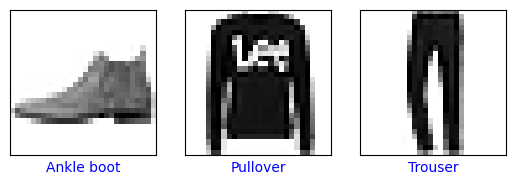

In [5]:
number_of_predictions = 3
get_predictions(model, number_of_predictions)

# Scan the Safe Model 

The scan results include information on the files scanned, and any issues if found. For the safe model scanned, modelscan finds no model serialization attacks, as expected.

In [6]:
!modelscan -p ./TensorFlowModels/safe_model

No settings file detected at /Users/mehrinkiani/Documents/modelscan/notebooks/modelscan-settings.toml. Using defaults. 

Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/safe_model/fingerprint.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/safe_model/keras_metadata.pb using modelscan.scanners.SavedModelLambdaDetectScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/safe_model/saved_model.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan

--- Summary ---

 No issues found! 🎉

--- Skipped --- 

Total skipped: 2 - run with --show-skipped to see the full list.


# Model Serialization Attack

Here malicious code is injected in the safe model to read aws secret keys. The unsafe model is saved at `./TensorFlowModels/unsafe_model`

In [7]:
unsafe_model = MaliciousModule(model)
unsafe_model.build(input_shape=(None, 28, 28))

# Save the unsafe model
unsafe_model_path = os.path.join(model_directory, "unsafe_model")
unsafe_model.save(unsafe_model_path)

# Unsafe Model Prediction

The malicious code injected in the unsafe model gets executed when it is loaded. The aws secret keys are displayed. 

Also, the unsafe model predicts the clothing items just as well as safe model i.e., the code injection attack will not impact the model performance. The unaffected performance of unsafe models makes the ML models an effective attack vector. 

File found: /tmp/aws_secret.txt
aws_access_key_id=<access_key_id>
aws_secret_access_key=<aws_secret_key>
1/1 [==============================] - 0s 48ms/step

The model predicts: ['Ankle boot', 'Pullover', 'Trouser'] with probabilities: [ 94.768  65.806 100.   ]

The true labels are ['Ankle boot', 'Pullover', 'Trouser']


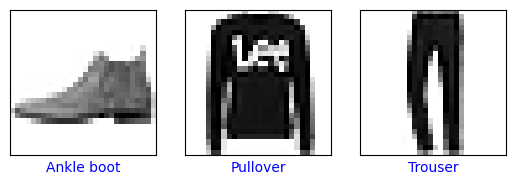

In [8]:
unsafe_model_loaded = tf.keras.models.load_model(unsafe_model_path)

number_of_predictions = 3
get_predictions(unsafe_model_loaded, number_of_predictions)

# Scan the Unsafe Model

The scan results include information on the files scanned, and any issues if found. In this case, a critical severity level issue is found in the unsafe model scanned. 

modelscan also outlines the found operator(s) and module(s) deemed unsafe. 

In [9]:
!modelscan -p TensorFlowModels/unsafe_model

No settings file detected at /Users/mehrinkiani/Documents/modelscan/notebooks/modelscan-settings.toml. Using defaults. 

Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/fingerprint.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/keras_metadata.pb using modelscan.scanners.SavedModelLambdaDetectScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/saved_model.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan

--- Summary ---

Total Issues: 2

Total Issues By Severity:

    - LOW: 0
    - MEDIUM: 0
    - HIGH: 2
    - CRITICAL: 0

--- Issues by Severity ---

--- HIGH ---

Unsafe operator found:
  - Severity: HIGH
  - Description: Use of unsafe operator 'ReadFile' from module 'Tensorflow'
  - Source: /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/sav

# Reporting Format
ModelScan can report scan results in console (default), JSON, or custom report (to be defined by user in settings-file). For mode details, please see:  ` modelscan -h` 

## JSON Report

For JSON reporting: `modelscan -p ./path-to/file -r json -o output-file-name.json` 

In [10]:
# This will save the scan results in file: tensorflow-model-scan-results.json
!modelscan --path  TensorFlowModels/unsafe_model -r json -o tensorflow-model-scan-results.json

No settings file detected at /Users/mehrinkiani/Documents/modelscan/notebooks/modelscan-settings.toml. Using defaults. 

Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/fingerprint.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/keras_metadata.pb using modelscan.scanners.SavedModelLambdaDetectScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/saved_model.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan
{"modelscan_version": "0.5.0", "timestamp": "2024-01-25T17:56:46.559473", 
"input_path": 
"/Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model"
, "total_issues": 2, "summary": {"total_issues_by_severity": {"LOW": 0, 
"MEDIUM": 0, "HIGH": 2, "CRITICAL": 0}}, "issues_by_severity": {"HIGH": 
[{"description": "Use of unsafe operator 'ReadFile' from modu